## Import the needed libraries

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
from sklearn.preprocessing import normalize

# Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import seaborn as sns

#Neuronal networks
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.models import Sequential,load_model
import keras
import utils

Using TensorFlow backend.


## Convert MP3 to WAV

All tracks should be change to wav format in order to work easily whit python

In [2]:
path = '.\\data\\fma_small'
#utils.all_mp3_to_wav(path)

## Read metadata

In [3]:
AUDIO_DIR='.\\data\\fma_small'
META_DIR='.\\data\\fma_metadata'

features = utils.load(META_DIR+'\\features.csv')
echonest = utils.load(META_DIR+'\\echonest.csv')
genres = utils.load(META_DIR+'\\genres.csv')
tracks = utils.load(META_DIR+'\\tracks.csv')
#raw_tracks = utils.load(META_DIR+'\\raw_tracks.csv')
artists = utils.load(META_DIR+'\\raw_artists.csv')



C:\Users\User_01\Documents\Master\DeepLearning\Proyecto\fma\utils.py:232: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  'category', categories=SUBSETS, ordered=True)


## Get small subset of data

In [4]:
# Creating the subset 
small = tracks[tracks['set', 'subset'] <= 'small']

# Splitind song IDs by train/test/validation
ids_train = small[small['set', 'split'] == 'training'].index
ids_test = small[small['set', 'split'] == 'test'].index
ids_validation = small[small['set', 'split'] == 'validation'].index

## Explore features of tracks using an arbitrary example

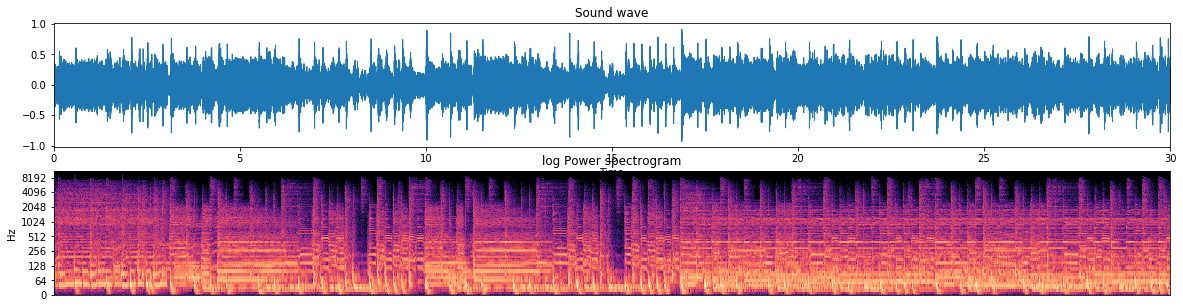

In [5]:
# Getting an arbitrary example
tid_example = 122077
filepath = utils.get_audio_path(AUDIO_DIR,tid_example)
example, sr = librosa.load(filepath, sr=None, mono=True)
example_S, phase = librosa.magphase(librosa.stft(example)) 

#Plotting representation of the track
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.title('Sound wave')
librosa.display.waveplot(example, sr=sr)
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(example_S, ref=np.max), y_axis='log')
plt.title('log Power spectrogram')
plt.show()

ipd.Audio(filepath) 

### Constant-Q chromagram, Chroma Energy Normalized y stft Chornogram
#### Explanation:
https://en.wikipedia.org/wiki/Constant-Q_transform 
https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/

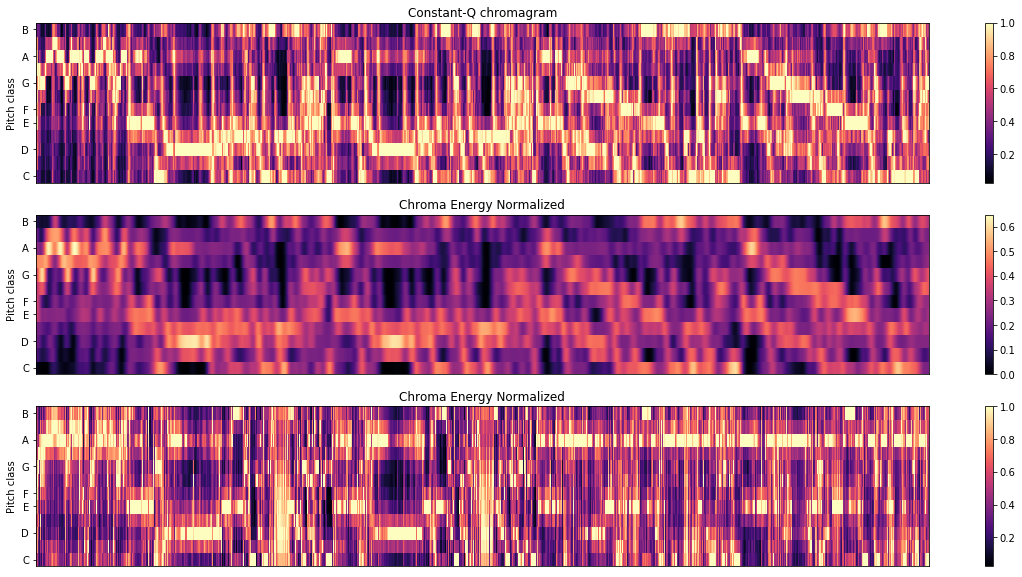

In [6]:
chroma_cq   = librosa.feature.chroma_cqt(y=example, sr=sr)
chroma_cens = librosa.feature.chroma_cens(y=example, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=example, sr=sr)

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
librosa.display.specshow(chroma_cq, y_axis='chroma')
plt.title('Constant-Q chromagram')
plt.colorbar()
plt.subplot(3,1,2)
librosa.display.specshow(chroma_cens, y_axis='chroma')
plt.title('Chroma Energy Normalized')
plt.colorbar()
plt.subplot(3,1,3)
librosa.display.specshow(chroma_stft, y_axis='chroma')
plt.title('Chroma Energy Normalized')
plt.colorbar()
plt.show()

### Root Mean Square (RMS) energy 
#### Explanation:
https://en.wikipedia.org/wiki/Root_mean_square

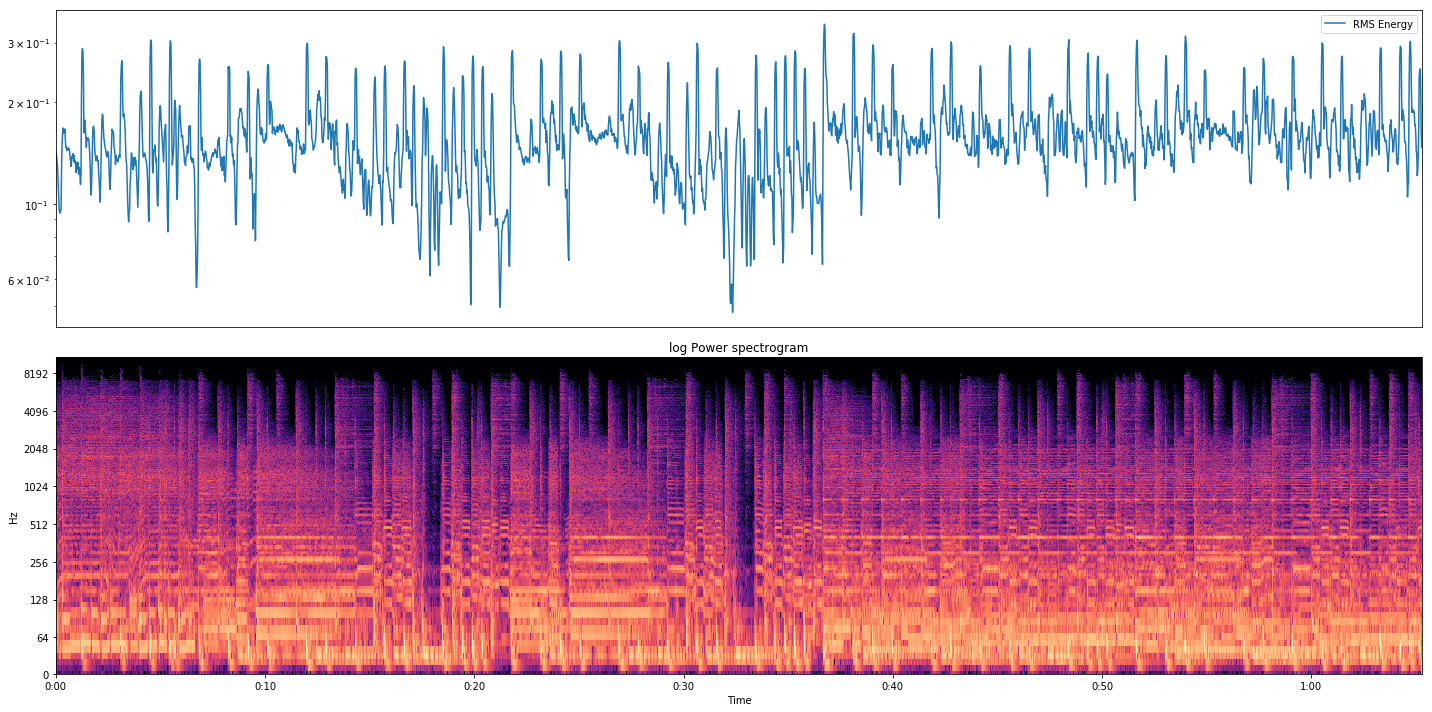

In [7]:
rmse =  librosa.feature.rmse(y=example)


plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.semilogy(rmse.T, label='RMS Energy')
plt.xticks([])
plt.xlim([0, rmse.shape[-1]])
plt.legend(loc='best')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(example_S, ref=np.max),  y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

### spectral_centroid spectral_bandwidth spectral_contrast spectral_rolloff
#### Explanation:
https://en.wikipedia.org/wiki/Roll-off


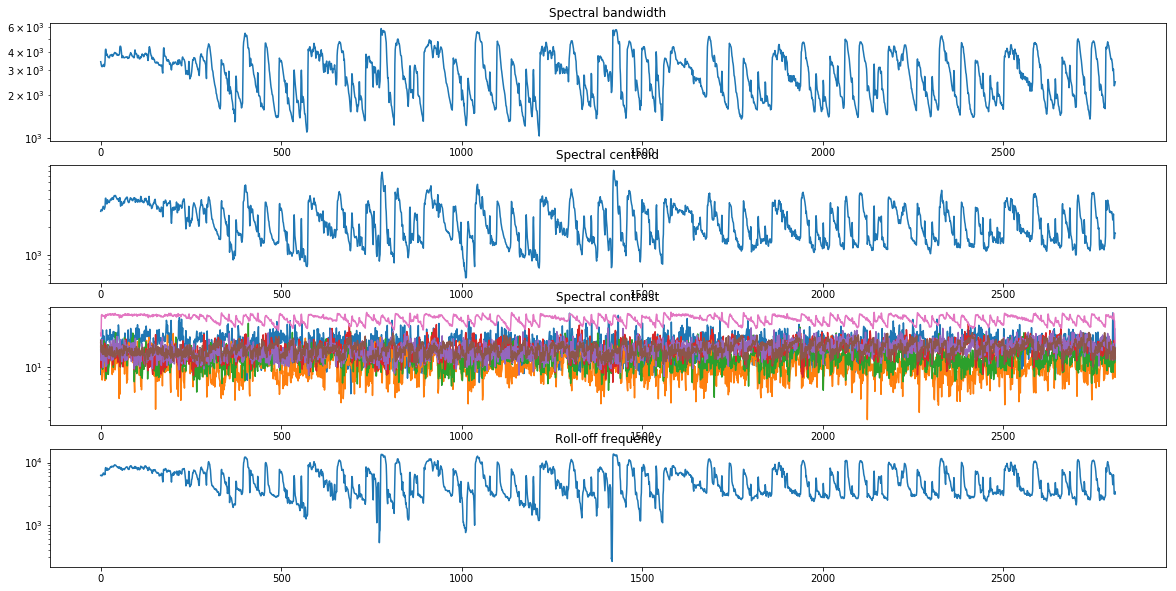

In [8]:
bandwidth = librosa.feature.spectral_bandwidth(y=example, sr=sr)
centroid  = librosa.feature.spectral_centroid(y=example, sr=sr)
contrast  = librosa.feature.spectral_contrast(y=example, sr=sr, n_bands=6)
rolloff   = librosa.feature.spectral_rolloff(y=example, sr=sr)

plt.figure(figsize=(20,10)) 
plt.subplot(4,1,1)
plt.semilogy(bandwidth.T)
plt.title('Spectral bandwidth')
  
plt.subplot(4,1,2)
plt.semilogy(centroid.T)
plt.title('Spectral centroid')

plt.subplot(4,1,3)
plt.semilogy(contrast.T)
plt.title('Spectral contrast')

plt.subplot(4,1,4)
plt.semilogy(rolloff.T)
plt.title('Roll-off frequency')
plt.show()


### Mel Frequency Cepstral Coeﬃcients
#### Explanation:
https://en.wikipedia.org/wiki/Mel_scale
https://es.wikipedia.org/wiki/MFCC

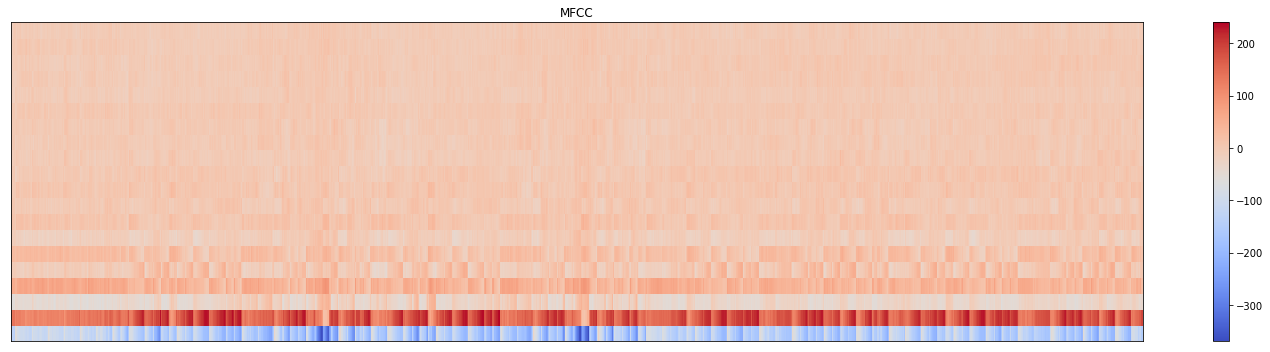

In [9]:
mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =20)

plt.figure(figsize=(20,5))
librosa.display.specshow(mfcc)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Preparation of data

In [10]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [11]:
freqs, times, spectrogram = log_specgram(example,sr)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_ylabel('Amplitud')
ax1.plot(np.linspace(0, sr/len(example), sr), example)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_ylabel('Frecuencias en Hz')
ax2.set_xlabel('Segundos')
plt.show()

# Fully connected network

In [12]:
# merging genres with features
features_2_level = features.copy()
features_2_level.columns = features_2_level.columns.droplevel(2)
tracks_features = np.array(pd.merge(tracks['track','genre_top'].to_frame(), features_2_level, left_index=True, right_index=True).values)



In [13]:
# Taking 8 main genres
top_genres = pd.unique(small['track','genre_top'])
number_of_top_genders=len(top_genres)
top_genred_features = tracks_features[np.isin(tracks_features[:,0],top_genres)]

In [22]:
# Oneshot genres
def one_shot_genre(genre,list_genre):
    return 1*np.array(list_genre == genre)

        

genre_oneshot = []
for genre in top_genred_features[:,0]:
    genre_oneshot.append(one_shot_genre(genre,top_genres ))
    

final_data = np.concatenate((top_genred_features,genre_oneshot),axis=1)

Hip-Hop
Hip-Hop
Hip-Hop
Pop
Hip-Hop
Rock
Rock
Experimental
Experimental
Folk
Folk
Folk
Folk
Experimental
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Pop
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Ro

Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Rock
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
International
International
International
International
International
Experimental
Experimental
Rock
Rock
International
Rock
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Electronic
Electronic
Electron

Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Rock
Rock
Rock
Hip-Hop
Experimental
Electronic
Folk
Folk
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
International
Electronic
Rock
Rock
Electronic
Hip-Hop
Rock
Rock
Rock
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrume

Rock
Rock
Rock
Folk
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Folk
Experimental
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
International
International
Hip-Hop
Hip-Hop
Hip-Hop
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Rock
Experimental
Experimental
Experimental
Experimental
Rock
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Ele

Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Experimental
Experimental
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Electronic
Electronic
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic


Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Hip-Hop
Hip-Hop
Electronic
Rock
Pop
Hip-Hop
Pop
Pop
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
International
International
International
International
International
International
International
International
International
International
International
Interna

Folk
Folk
Folk
Folk
Folk
Folk
Folk
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Pop
Rock
Electronic
Electronic
Electronic
Pop
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Instrumental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Experimental
Experimental
Experimental
Experimental
Experimental
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Pop
Pop
Pop
Pop
Pop
Pop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Roc

Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Rock
Rock
Rock
Rock
Rock
Rock
Folk
Folk
Folk
Folk
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Pop
Pop
Pop
Pop
Pop
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Ho

Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Folk
Folk
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
International
International
International
International
International
International
International
International
International
International
International
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
International
International
International
Internation

Experimental
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
International
International
International
International
International
International
International
International
International
International
International
International
International
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
International
International
International
International
Folk
Folk
Experimental
Experimental
Experimental
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Ex

Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Folk
Folk
Folk
Folk
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Rock
Rock
Rock
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experim

Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Pop
Pop
Pop
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Exp

Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Elec

Rock
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Experimental
Rock
Folk
Folk
Folk
Folk
Folk
Folk
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Folk
International
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
International
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Elect

Electronic
Electronic
Electronic
Electronic
Experimental
Experimental
Experimental
Experimental
Folk
Folk
Folk
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Pop
Pop
Pop
Pop
Pop
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Ex

Experimental
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimenta

Instrumental
Instrumental
Instrumental
Instrumental
Rock
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Experimental
Experimental
Experimental
Experimental
Experimental
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Pop
Instrumental
Instrumen

Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Hip-Hop
Hip-Hop
Hip-Hop
Hip-Hop
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Electronic
Electronic
Electronic
Experimental
Experimental
Experimental
Experimental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Instrumental
Experimental
Experimental
Experi

Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Rock
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
E

Experimental
Experimental
Experimental
Experimental
Experimental
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Rock
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Folk
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Rock
Pop
Pop
Pop
Pop
Pop
Pop
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Experimental
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
International
International
International
International
International
International
International
International
International
International
International
International
International
International
International
International
International
International
Electronic
Electronic
Electronic
Electronic
Electronic
Electronic
Experimental
Experimental
Instrumental
Instrumental
Instr

In [18]:
# Preparing train and test data
TRAIN_PERCENTAGE=0.7

np.random.shuffle(final_data)

x_train = normalize(final_data[:int(final_data.shape[0]*TRAIN_PERCENTAGE),1:-len(top_genres)],axis=0)
y_train = final_data[:int(final_data.shape[0]*TRAIN_PERCENTAGE),-number_of_top_genders:]

x_test = normalize(final_data[int(final_data.shape[0]*TRAIN_PERCENTAGE):,1:-len(top_genres)],axis=0)
y_test = final_data[int(final_data.shape[0]*TRAIN_PERCENTAGE):,-number_of_top_genders:]


In [19]:
# modelo
HIDDEN_SIZE_L1=32
HIDDEN_SIZE_L2=32

model = Sequential()
model.add(Dense(HIDDEN_SIZE_L1, activation='tanh',input_dim=np.shape(x_train)[1]))
model.add(Dense(HIDDEN_SIZE_L2, activation='tanh'))
model.add(Dense(number_of_top_genders, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                16608     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
Total params: 17,928
Trainable params: 17,928
Non-trainable params: 0
_________________________________________________________________


In [20]:
# training model

BATCH_SIZE = 64
n_iteraciones = 100
for iteracion in range(1, n_iteraciones+1):
    print()
    print('-' * 50)
    print('Iteracion %d de %d' % (iteracion, n_iteraciones))
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=10,
              validation_data=(x_test, y_test))


--------------------------------------------------
Iteracion 1 de 100
Train on 32421 samples, validate on 13896 samples
Epoch 1/10
32421/32421 [==============================] - 2s 48us/step - loss: 0.3516 - acc: 0.8740 - val_loss: 0.3210 - val_acc: 0.8750
Epoch 2/10
32421/32421 [==============================] - 1s 28us/step - loss: 0.2922 - acc: 0.8869 - val_loss: 0.2760 - val_acc: 0.8939
Epoch 3/10
32421/32421 [==============================] - 1s 27us/step - loss: 0.2668 - acc: 0.8977 - val_loss: 0.2626 - val_acc: 0.8982
Epoch 4/10
32421/32421 [==============================] - 1s 27us/step - loss: 0.2563 - acc: 0.9014 - val_loss: 0.2551 - val_acc: 0.9017
Epoch 5/10
32421/32421 [==============================] - 1s 27us/step - loss: 0.2486 - acc: 0.9041 - val_loss: 0.2489 - val_acc: 0.9055
Epoch 6/10
32421/32421 [==============================] - 1s 28us/step - loss: 0.2426 - acc: 0.9072 - val_loss: 0.2456 - val_acc: 0.9067
Epoch 7/10
32421/32421 [==============================] -

KeyboardInterrupt: 

In [69]:
# Evaluation of the network
loss_train, score_train = model.evaluate(x_train,y_train, verbose=0)
loss_val, score_val = model.evaluate(x_test,y_test, verbose=0)
print()
print("Loss  in training  :", loss_train)
print("Score in training  :", score_train)
print()
print("Loss  in validation:", loss_val)
print("Score in validation:", score_val)


Loss  in training  : 0.21573764688622993
Score in training  : 0.9187370839869342

Loss  in validation: 0.2492037500604927
Score in validation: 0.9080130972941853


# Recurrent netwok

In [56]:
# Get sound feature mfcc from
mfcc_tracks_train = []
i=0
id_small_train = small[small['set','split'] == 'training'].index
for id_track in id_small_train:
    filepath = utils.get_audio_path(AUDIO_DIR,id_track)
    example, sr = librosa.load(filepath, sr=None, mono=True)
    mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =20)
    mfcc_labeled = [mfcc,one_shot_genre(small.iloc[id_track]['track','genre_top'],top_genres)]
    np.append(mfcc_tracks_train,mfcc_labeled)
    i+=1
    if i %100 == 0:
        print(len(mfcc_tracks_train))
i=0 
mfcc_tracks_test = []
for id_track in small[small['set','split'] == 'test'].index:
    filepath = utils.get_audio_path(AUDIO_DIR,id_track)
    example, sr = librosa.load(filepath, sr=None, mono=True)
    mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =20)
    mfcc_labeled = [mfcc,one_shot_genre(small.iloc[id_track]['track','genre_top'],top_genres)]
    np.append(mfcc_tracks_test,mfcc_labeled)
    i+=1
    if i == 0:
        print(len(mfcc_tracks_test))

0
0


KeyboardInterrupt: 

In [87]:
filepath = utils.get_audio_path(AUDIO_DIR,tid_example)
example, sr = librosa.load(filepath, sr=None, mono=True)
mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =20)

In [23]:
one_shot_genre(tracks.iloc[2]['track','genre_top'],top_genres)

array([1, 0, 0, 0, 0, 0, 0, 0])

In [27]:
[mfcc,one_shot_genre(tracks.iloc[2]['track','genre_top'],top_genres)]

[array([[-127.19683257, -116.3876111 , -117.22721916, ..., -148.54171883,
         -150.32622464, -148.70788325],
        [ 135.98693419,  140.46234934,  139.86957483, ...,  188.4835869 ,
          188.68259409,  190.18816293],
        [ -48.06552782,  -52.00677486,  -54.20238728, ...,  -32.36426495,
          -35.54367523,  -42.30598791],
        ...,
        [  -5.81061608,   -5.73505901,  -11.93826999, ...,    9.94261424,
           10.62711513,   11.60263542],
        [   6.02582012,   -1.04591947,   -5.17120504, ...,    4.43561701,
            1.57425858,    1.38122861],
        [  -3.76444252,  -10.24166159,   -9.8184001 , ...,   -5.81622353,
           -3.71974906,   -2.09052128]]), array([1, 0, 0, 0, 0, 0, 0, 0])]

In [59]:
filepath = utils.get_audio_path(AUDIO_DIR,2)
example, sr = librosa.load(filepath, sr=None, mono=True)
mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =20)
mfcc_labeled = [mfcc,one_shot_genre(small.iloc[id_track]['track','genre_top'],top_genres)]
np.append(mfcc_tracks_train,mfcc_labeled)

array([array([[-5.05499199e+02, -3.69049664e+02, -2.44568732e+02, ...,
        -5.93092565e+01, -6.19532225e+01, -6.53379088e+01],
       [-6.25595111e-14,  1.06318848e+02,  1.36043918e+02, ...,
         1.28443261e+02,  1.32779548e+02,  1.28757020e+02],
       [ 8.67040695e-14, -3.63369463e+00, -3.39448078e+01, ...,
        -5.66122210e+01, -6.60980259e+01, -6.92161943e+01],
       ...,
       [-4.65905556e-14, -8.17886682e+00, -5.86944004e+00, ...,
        -7.11918952e+00, -1.07483194e+01, -1.42973284e+01],
       [ 1.29397871e-14, -1.22518105e+01, -1.31030528e+01, ...,
         1.21249848e+00, -3.30166707e+00, -1.07891105e+01],
       [ 2.46634930e-14, -1.88282675e+01, -1.88599412e+01, ...,
        -1.02143134e-01,  1.10421354e+00, -2.94764626e+00]]),
       array([0, 0, 0, 0, 1, 0, 0, 0])], dtype=object)

In [62]:
np.shape(mfcc_labeled)

(2,)